In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import xlrd
from scipy.integrate import ode
from scipy import integrate
import xlsxwriter
from IPython.display import Image
import pandas as pd
import math as ma

In [41]:
comparision='table.png'
dt='data_table.png'
hand1='handcal-1.png'
hand2='handcal-2.png'
hand3='handcal-3.png'
hand4='handcal-4.png'
vartable='vartable.png'
sen='sen.png'
title='title.png'
logic='logic.png'
thermtable='thermtable.png'

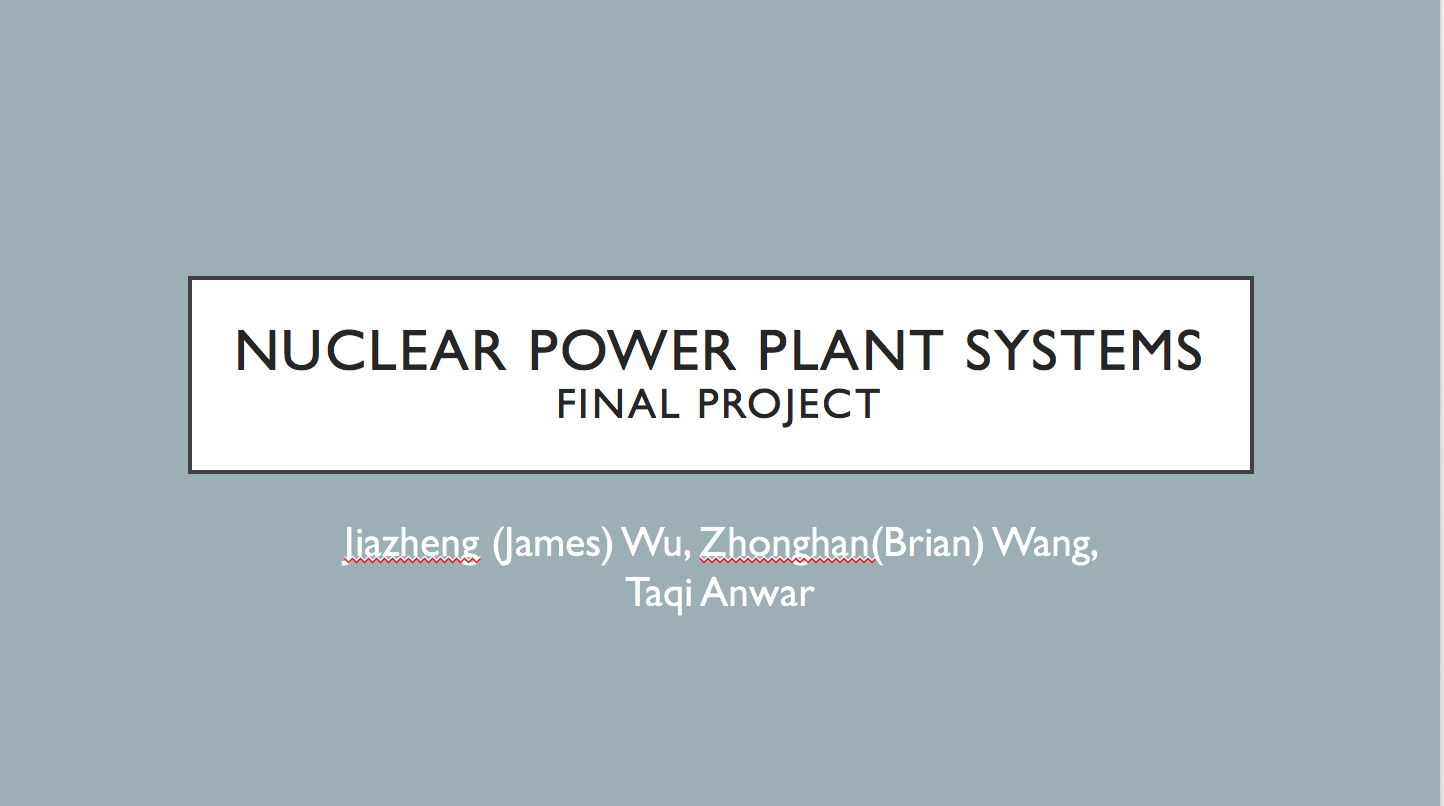

In [32]:
Image(title)

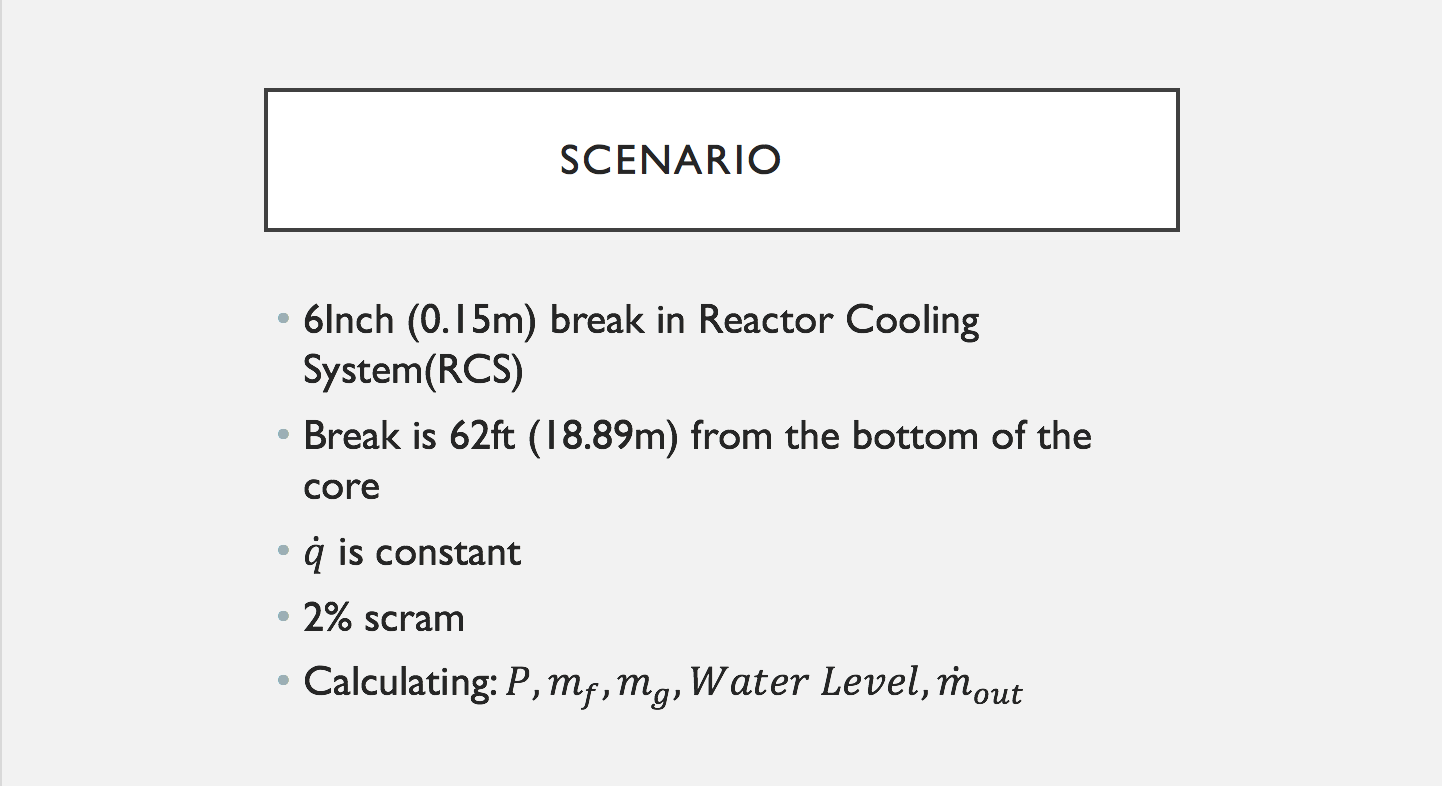

In [34]:
Image(sen)

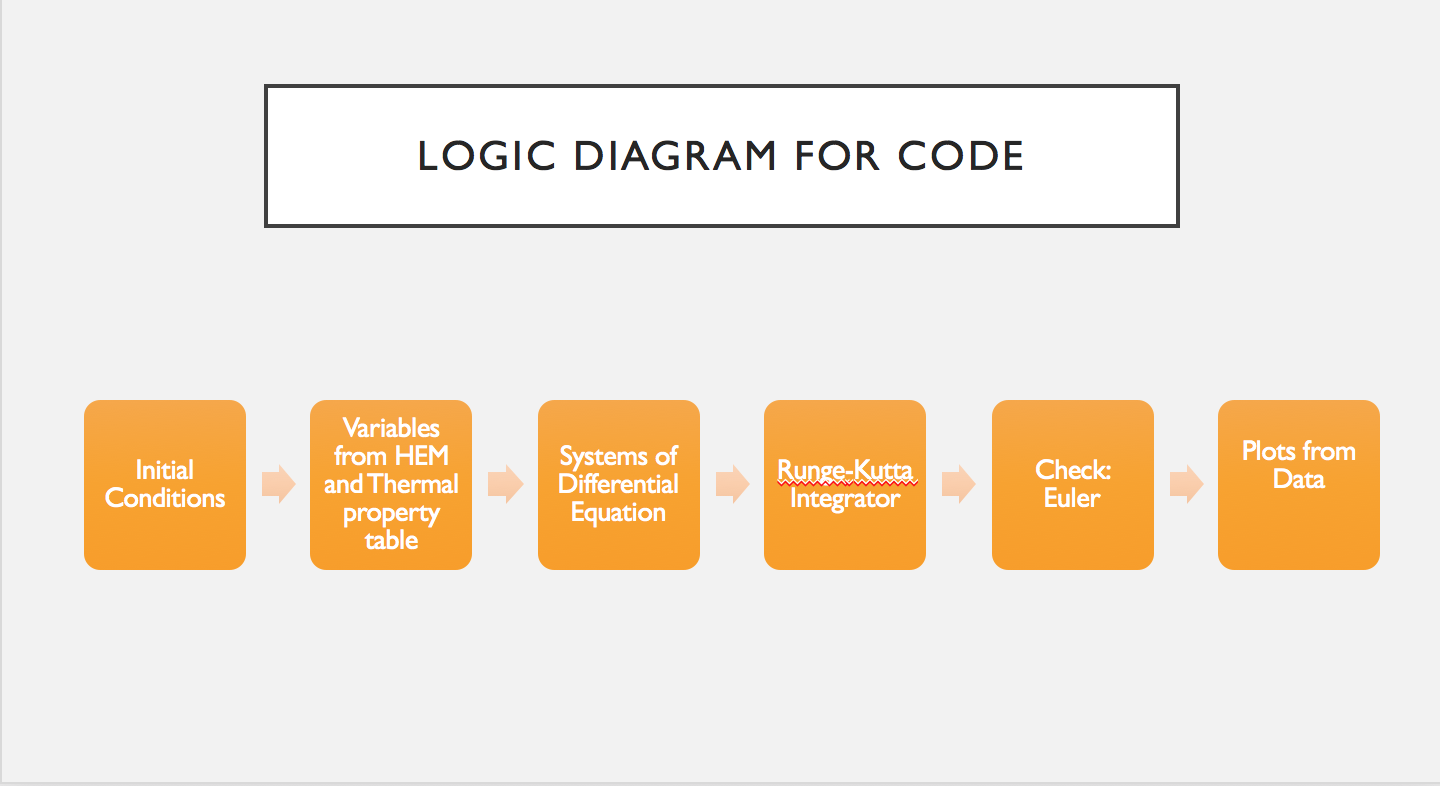

In [35]:
Image(logic)

## Initial Condition

In [4]:
# All in units of metric

HPSI=0.02524
temp_HPSI=32.22
Break_Area=0.01824
Break_Height=18.90
Cross_Area=6.503
RCS_temp=304.4
RCS_pressure=9142448
Water_V=287.7
Steam_V=50.97
hi=137000
qdot=64e6 #Assume 2% of 3200 MW


workbook = xlrd.open_workbook("C:/Users/Zhonghan/Desktop/nuclear_power_plant/Therm_Pressure_Table.xlsx")
Thermo_data=np.zeros([73,6])
for i in np.arange(73):
    for j in np.arange(6):
        Thermo_data[i,j]=workbook.sheet_by_index(1).cell_value(i+1,j)
        if j == 0 or j == 3 or j == 4:
            Thermo_data[i,j]= Thermo_data[i,j]*1000

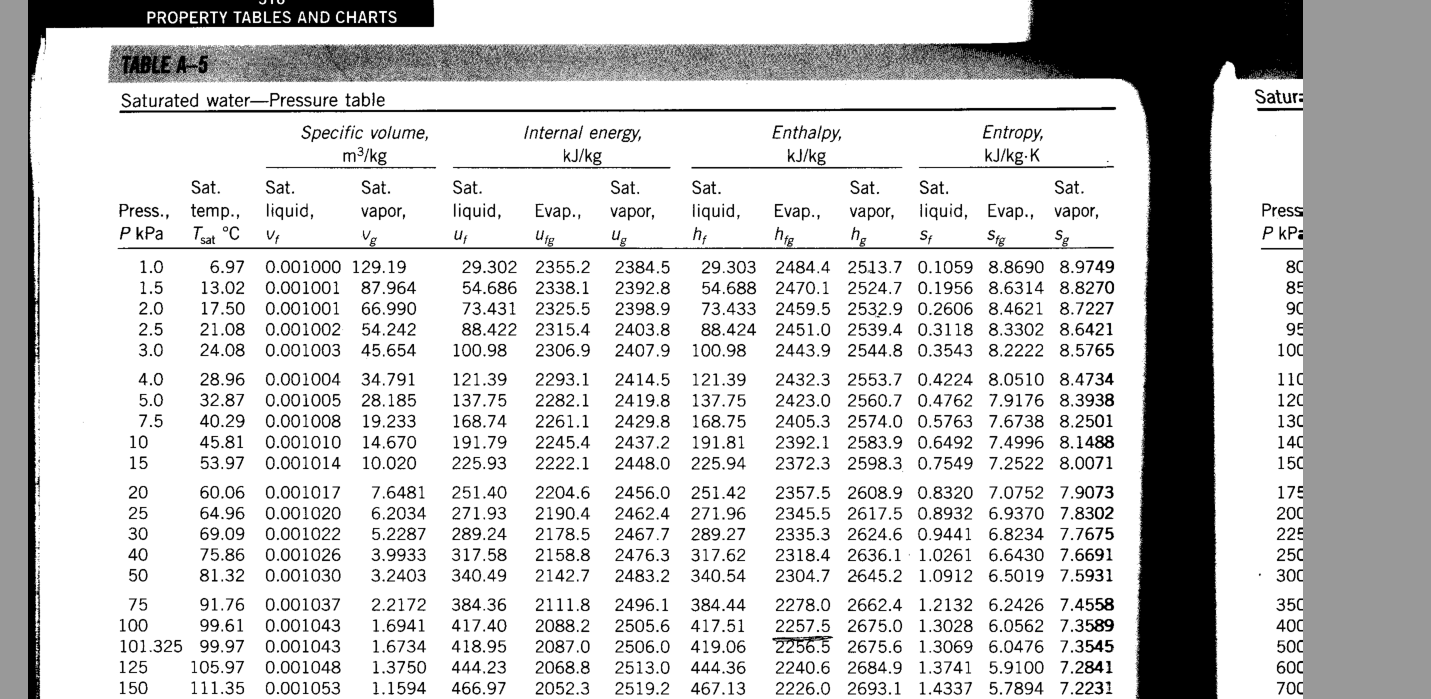

In [37]:
Image(thermtable)

## Variables of P

In [6]:
def vf(p=None): #returns vf, and slope at a pressure
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return ((Thermo_data[a,1]),(Thermo_data[a+1,1]-Thermo_data[a-1,1])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,1],(Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def vg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,2],(Thermo_data[a+1,2]-Thermo_data[a-1,2])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,2],(Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hf(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,3],(Thermo_data[a+1,3]-Thermo_data[a-1,3])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,3],(Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,4],(Thermo_data[a+1,4]-Thermo_data[a-1,4])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,4],(Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))
def mout_f(p=None):
    return(Break_Area*8300.54*(p/1378952)**0.71)
def mout_g(p=None):
    return(Break_Area*1953.0678*(p/1378952)**1.02)

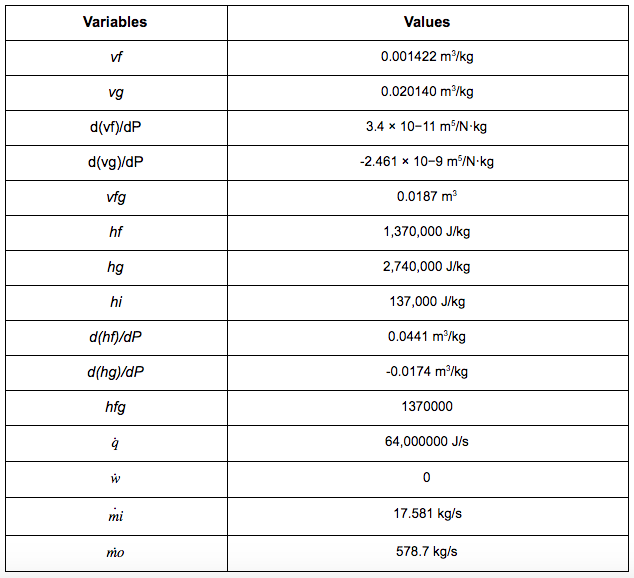

In [33]:
Image(vartable)

Some unit conversion

$$\dot{m}_{out.f}=1700 \frac{lb}{s \cdot ft^2} \times \left(\frac{P}{200 psia}\right)^{0.71}= 1700 \frac{lb}{s \cdot ft^2} \left(\frac{0.4536 kg}{1lb}\right)\left(\frac{1 ft^2}{0.0929 m^2}\right) \times \left(\frac{P}{200 psia}\frac{1psia}{6894.76 pa}\right)^{0.71}$$ 
$$=8300.54 \frac{kg}{s \cdot m^2} \times \left(\frac{P}{1,378,952 pascal}\right)^{0.71}$$

0.001422843232 0.020138435472


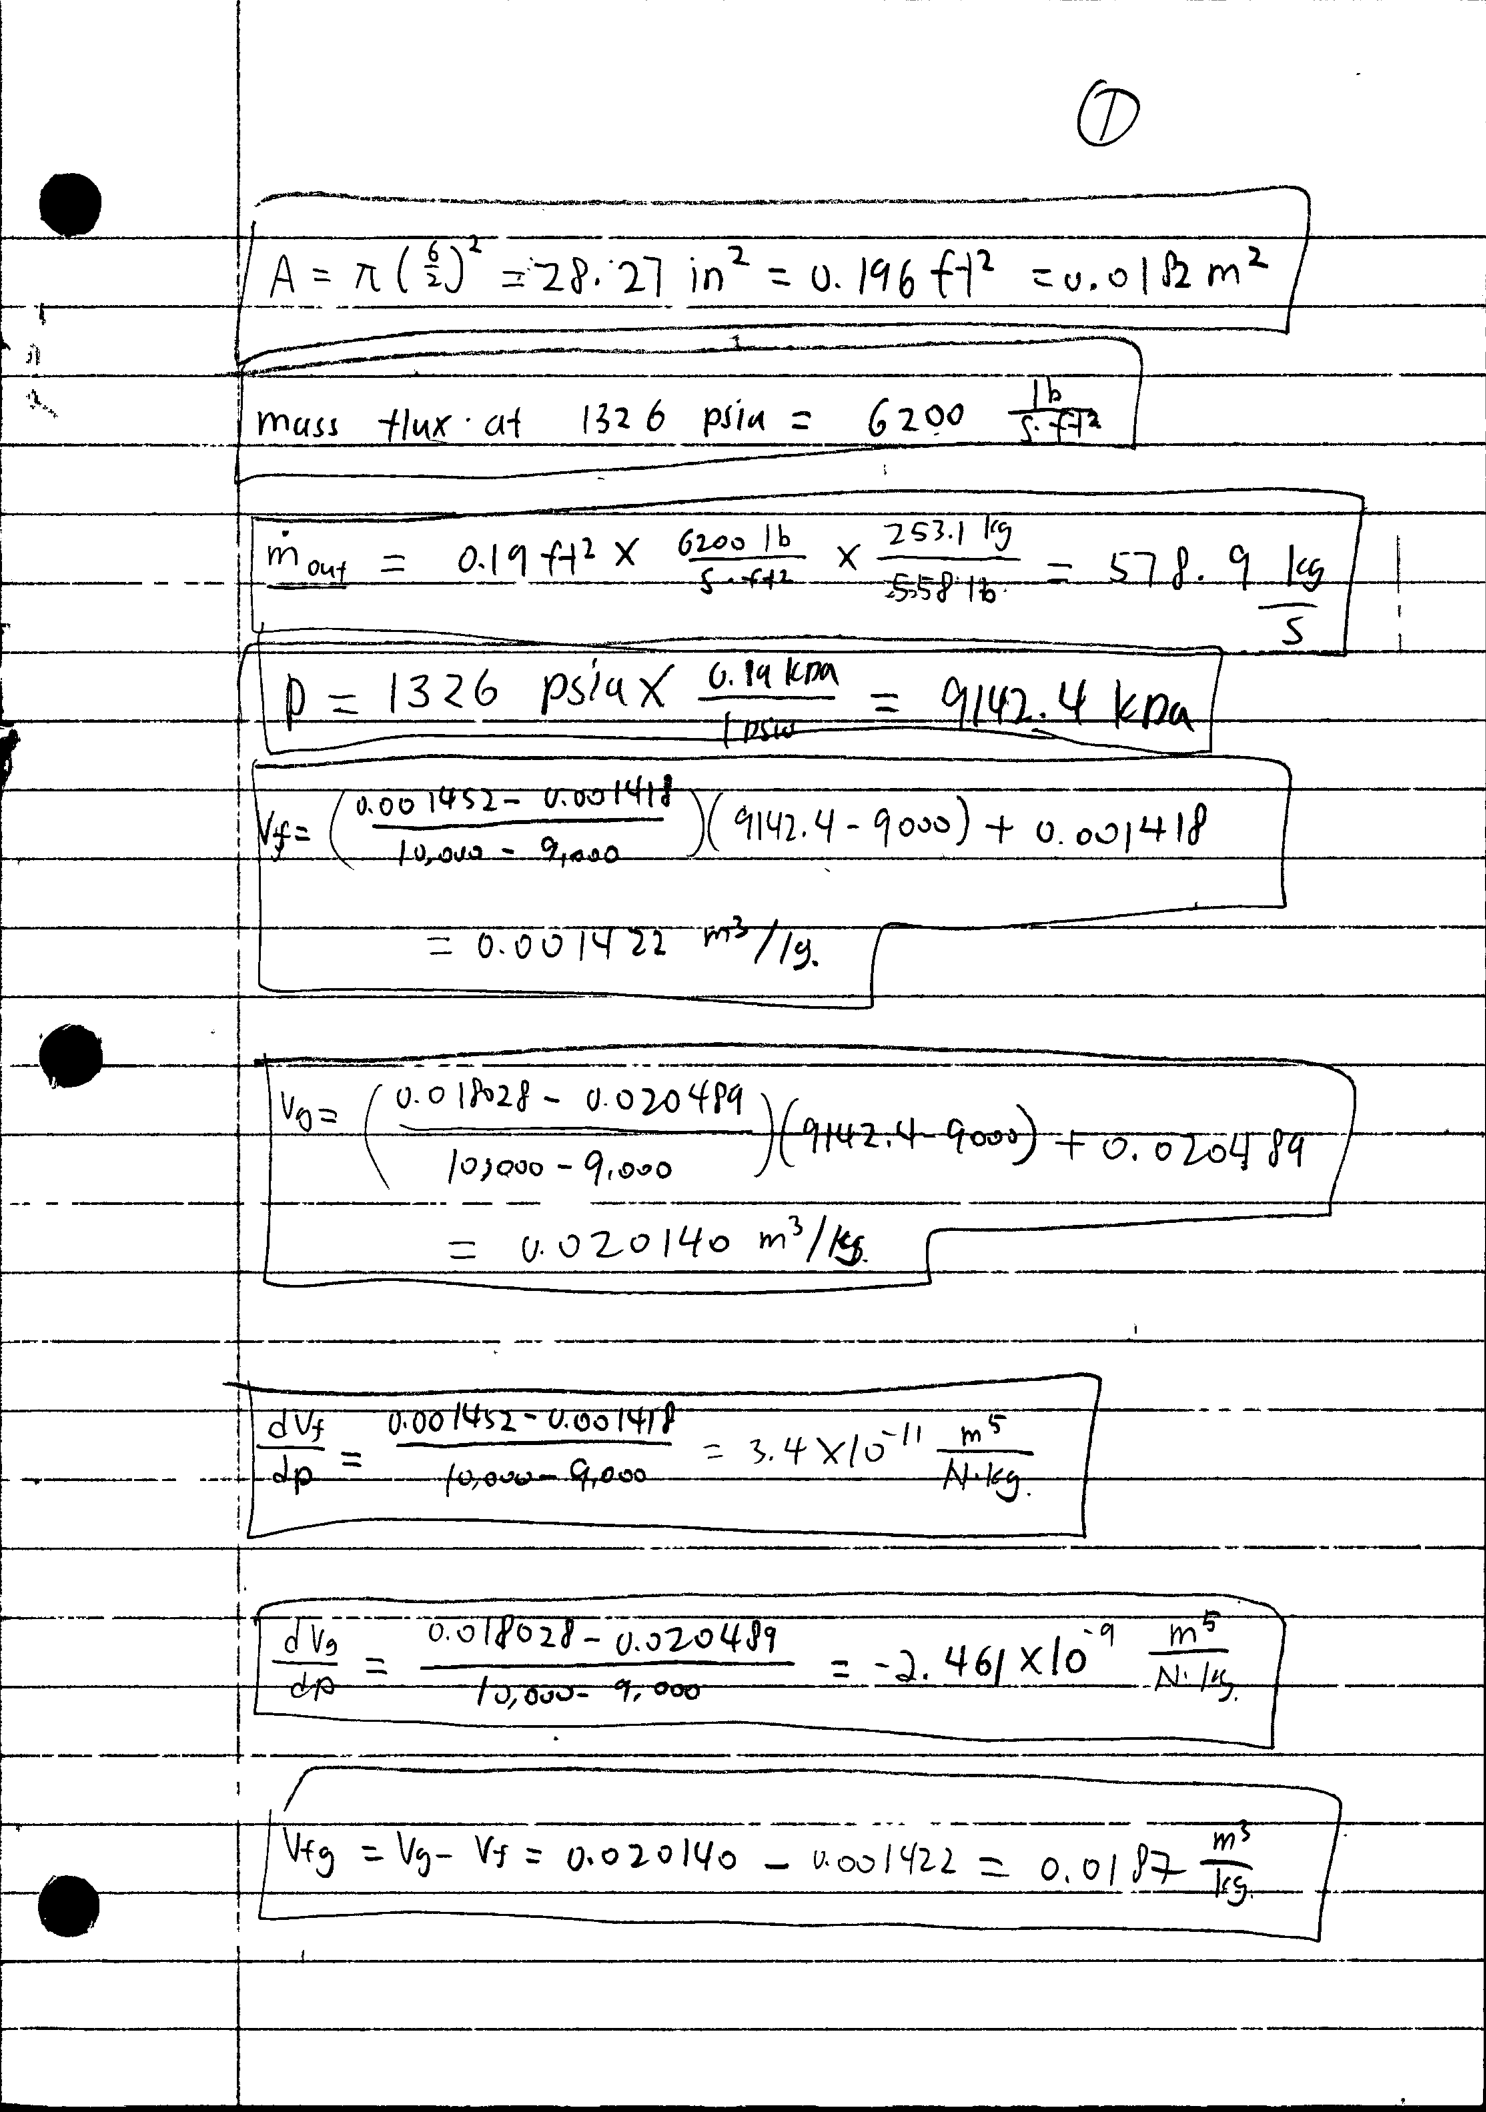

In [56]:
print(vf(RCS_pressure)[0],vg(RCS_pressure)[0])
Image(hand1)

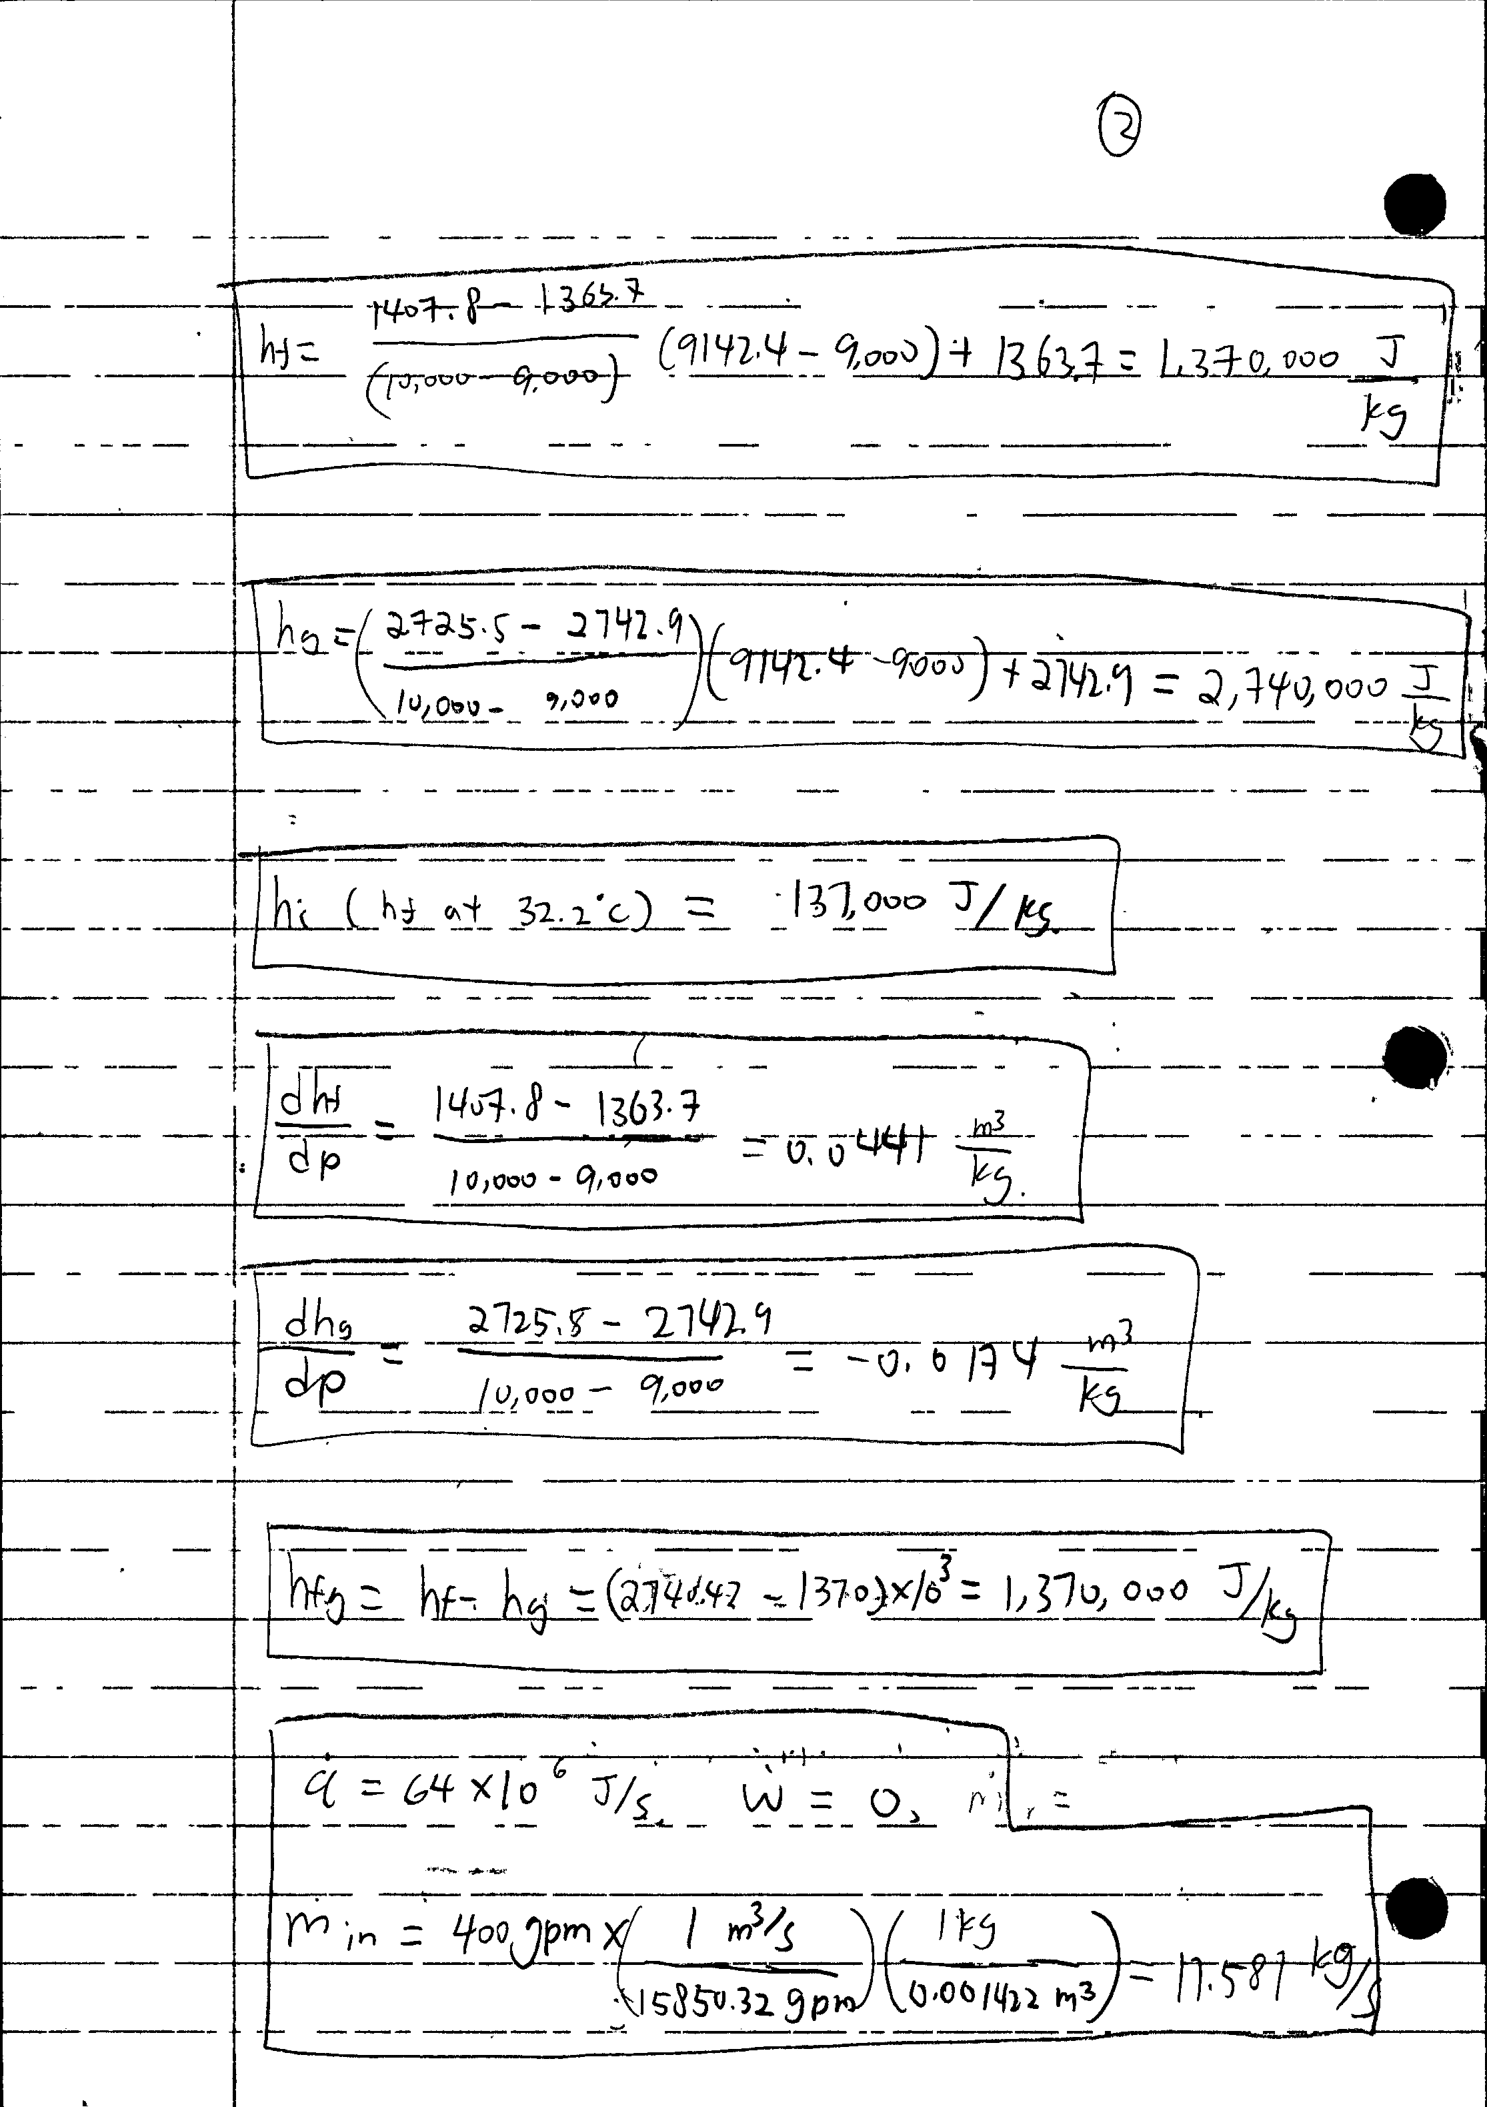

In [52]:
Image(hand2)

In [7]:
def system_eq1( t=None,y=None): # y is a vector [pressure, water mass, steam mass]
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hf(y[0])[0]*mout_f(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_f(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI/vf(y[0])[0]-mout_f(y[0])-(qdot/(hf(y[0])[0]-hi)),qdot/(hf(y[0])[0]-hi)]))

def system_eq2( t=None, y=None):
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hg(y[0])[0]*mout_g(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_g(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI/vf(y[0])[0]-(qdot/(hg(y[0])[0]-hi)),qdot/(hg(y[0])[0]-hi)-mout_g(y[0])]))

y0=np.array([RCS_pressure, Water_V/(vf(RCS_pressure)[0]), Steam_V/(vg(RCS_pressure)[0])])

The problem can be model as an IVP, using system of ODE of the form:
$$
\dfrac{\mathrm{d}}{\mathrm{dt}} \vec{y} = f(t,\vec{y}) \hspace{20 pt} y_0=y(t=0)
$$

We have two systems of ODE, one for when the water level is above the pipe break and the other for water level below the pipe break:

$$ \dfrac{\mathrm{d}}{\mathrm{dt}}\begin{bmatrix} P\\
M_{water} \\
M_{Steam}\end{bmatrix} = 
\begin{bmatrix} f(P,M_{water},M_{Steam})\\
g(P)\\
h(P)\end{bmatrix}=
\begin{bmatrix} \dfrac{v_{fg}\left(\sum (\dot{m}h)_j + \dot{q} - \dot{w}_s \right)+\sum \dot{m}_j (v_g h_{fg} - h_g v_{fg})}{v_{fg} \left( m_f \dfrac{\mathrm{d}h_f}{\mathrm{d}P} + m_g \dfrac{\mathrm{d}h_g}{\mathrm{d}P} - V \right) - h_{fg}\left( m_f \dfrac{\mathrm{d}v_f}{\mathrm{d}P} + m_g \dfrac{\mathrm{d}v_g}{\mathrm{d}P} \right)}\\
\dot{M}_{HPSI}-\dot{M}_{water.out}(P)-\dfrac{\dot{q}}{h_{f}(P)-h_{in}} \\
\dfrac{\dot{q}}{h_{f}(P)-h_{in}}\end{bmatrix} \tag{1}$$

$$ \dfrac{\mathrm{d}}{\mathrm{dt}}\begin{bmatrix} P\\
M_{water} \\
M_{Steam}\end{bmatrix} = 
\begin{bmatrix} f(P,M_{water},M_{Steam})\\
g(P)\\
h(P)\end{bmatrix}=
\begin{bmatrix} \dfrac{v_{fg}\left(\sum (\dot{m}h)_j + \dot{q} - \dot{w}_s \right)+\sum \dot{m}_j (v_g h_{fg} - h_g v_{fg})}{v_{fg} \left( m_f \dfrac{\mathrm{d}h_f}{\mathrm{d}P} + m_g \dfrac{\mathrm{d}h_g}{\mathrm{d}P} - V \right) - h_{fg}\left( m_f \dfrac{\mathrm{d}v_f}{\mathrm{d}P} + m_g \dfrac{\mathrm{d}v_g}{\mathrm{d}P} \right)}\\
\dot{M}_{HPSI}-\dfrac{\dot{q}}{h_{g}(P)-h_{in}} \\
-\dot{M}_{steam.out}(P)+\dfrac{\dot{q}}{h_{g}(P)-h_{in}}\end{bmatrix} \tag{2}$$

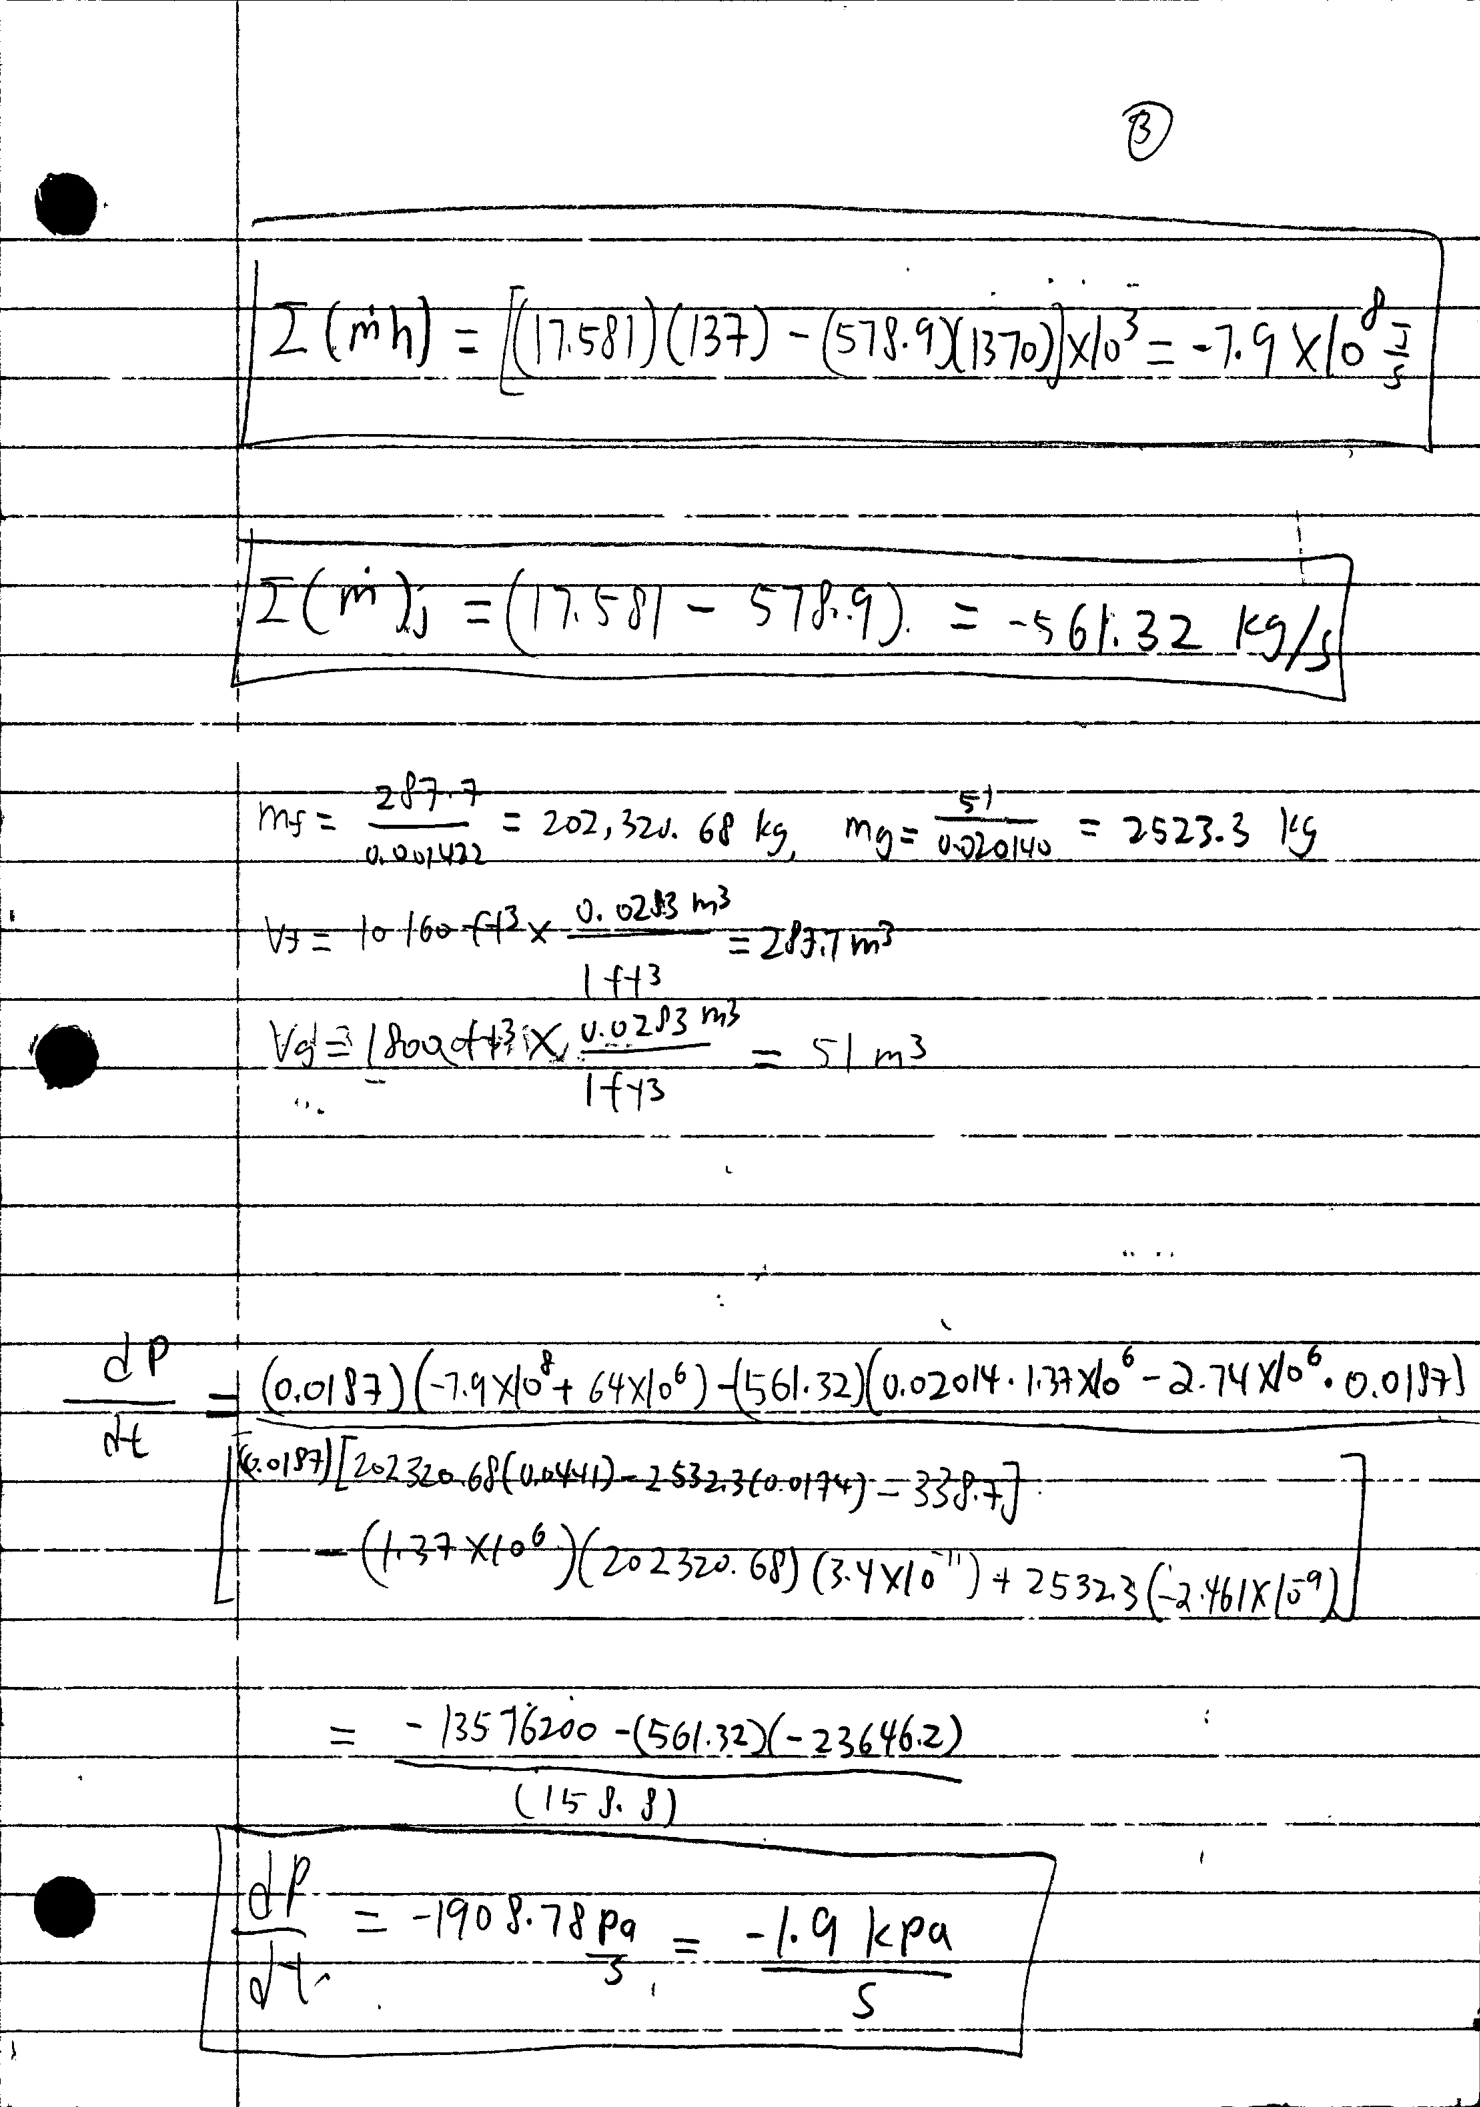

In [53]:
Image(hand3)

[-1938.15185994  -614.13772396    51.9066801 ]


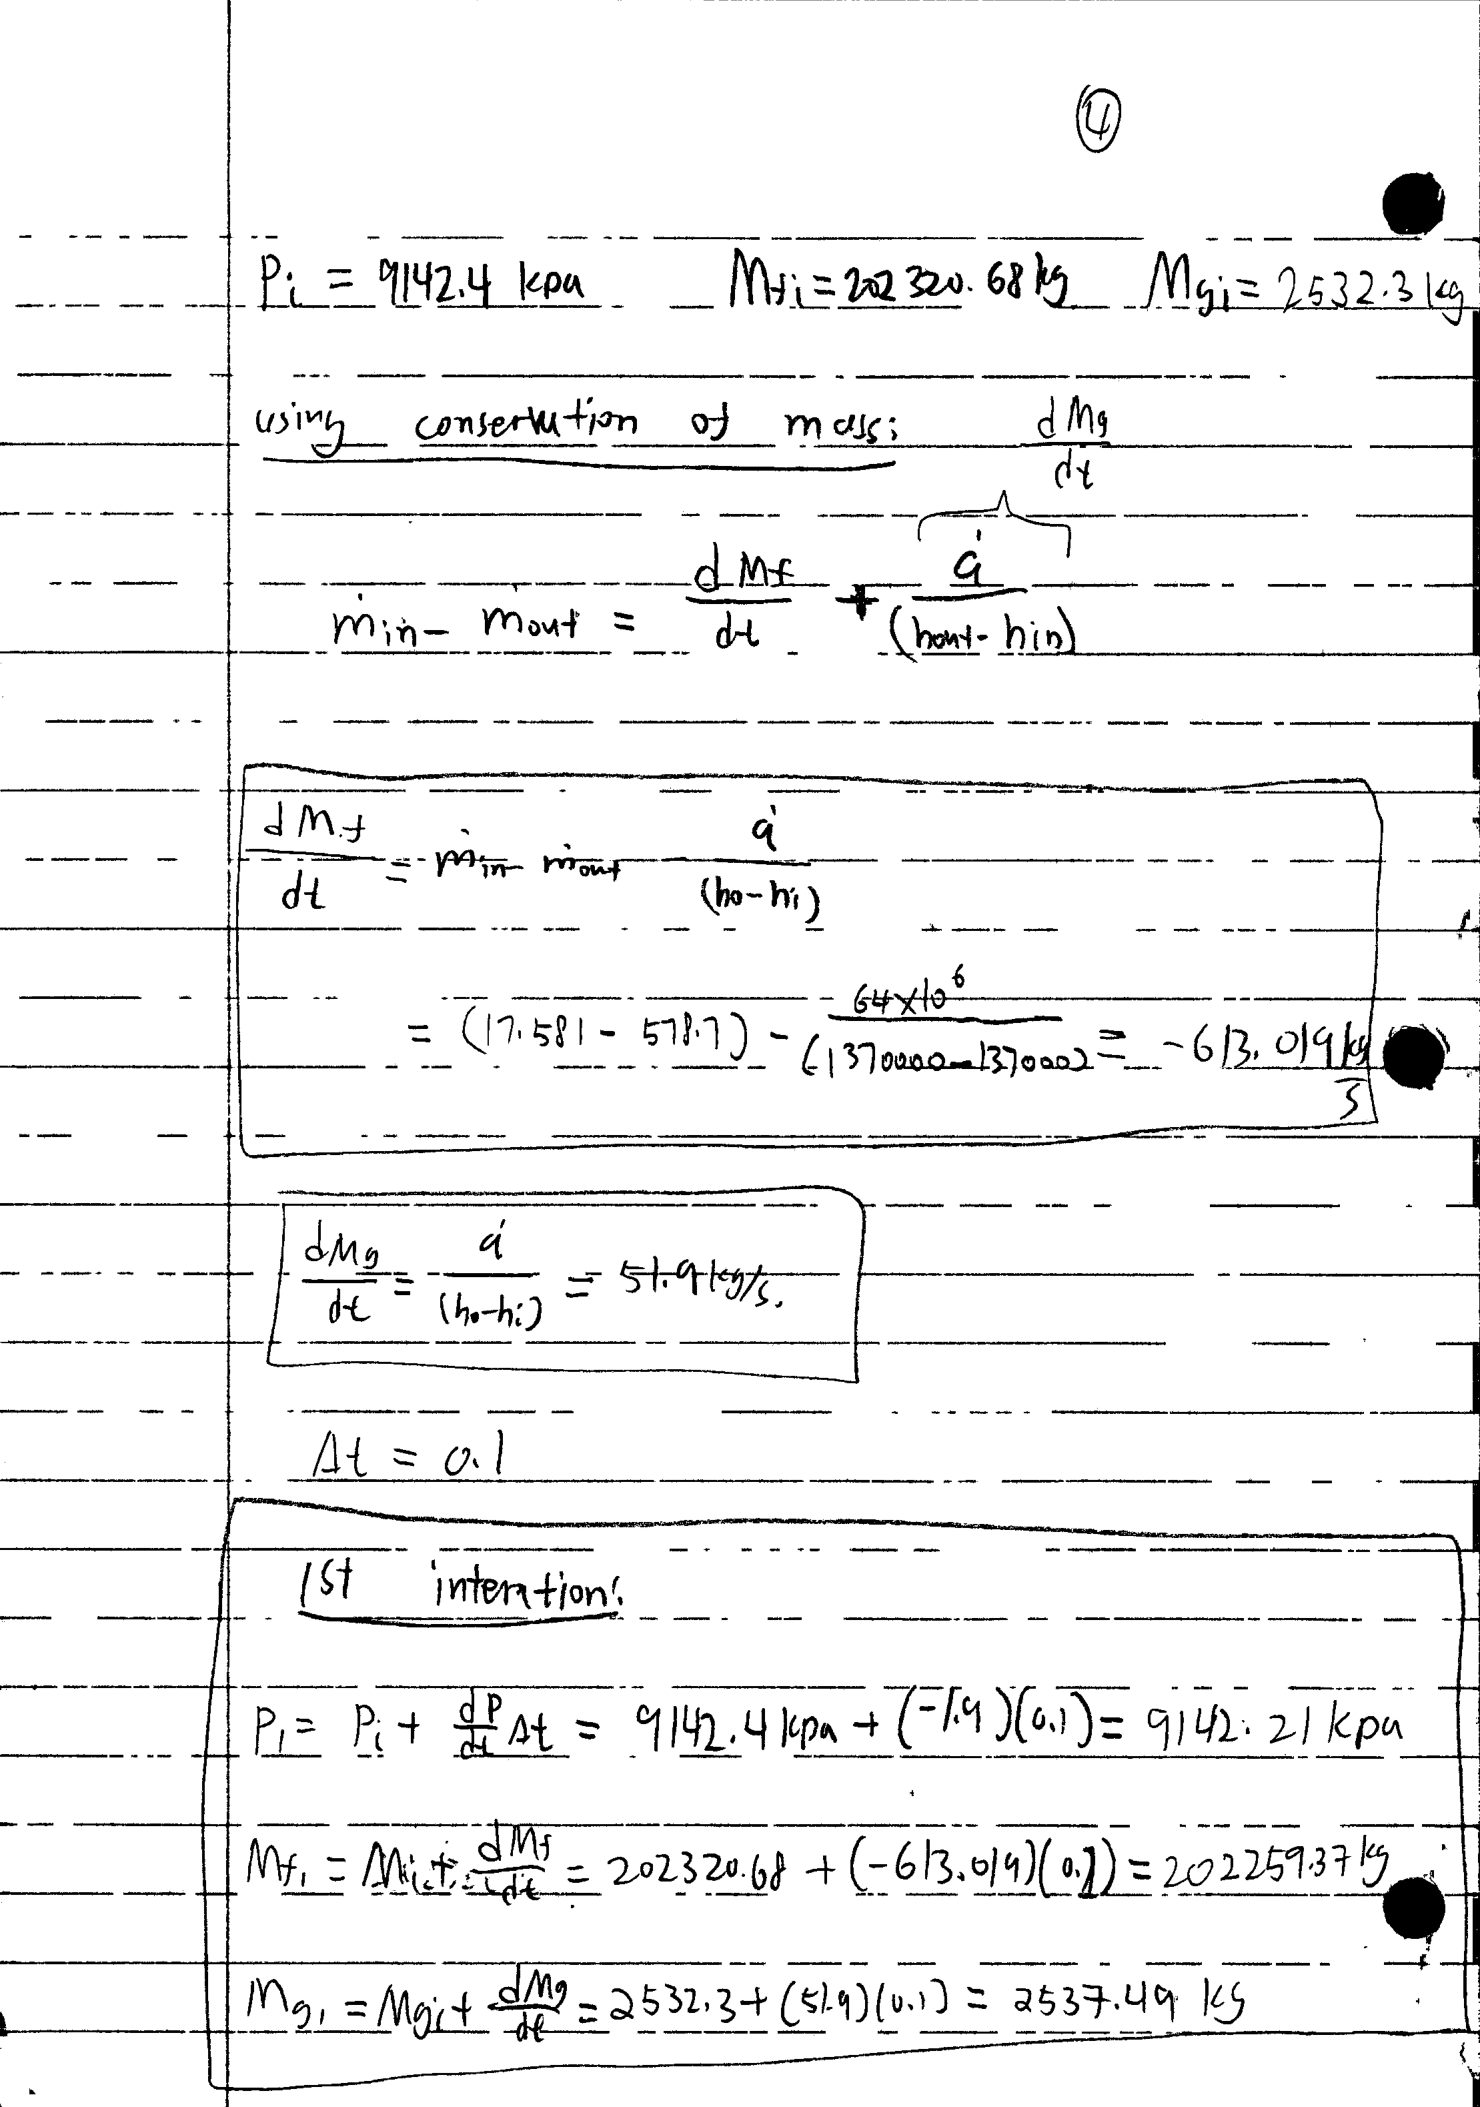

In [57]:
print(system_eq1(0,y0))
Image(hand4)

## Runge Kutta Integrator Method

In [8]:
Solver = ode(system_eq1).set_integrator("dopri5")
Solver.set_initial_value(y0,0)
t=0.1
i=1
val=Solver.integrate(t)

DATA1=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])

while DATA1[i,4] >  Break_Height: #62 ft
    t += 0.1
    i += 1
    val=Solver.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])


In [9]:
t_crit=t
i_crit=i

Solver2=ode(system_eq2).set_integrator("dopri5")
Solver2.set_initial_value(DATA1[i][1:4],t)
while DATA1[i,4] >  17.31: #56.79 ft
    t += 0.1
    i += 1
    val=Solver2.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])


In [59]:
print(t_crit,t)

189.8999999999935 264.2999999999916


Water level drops below the pipe break **189.9** seconds after the break, and core begin uncover at **264.3** second.

## Euler Method

$$
\vec{y}(t+\Delta{t})=\vec{y}(t)+f(t, \vec{y}) \cdot \Delta t
$$

### Time Step = 10 sec

In [10]:
def Euler_Method(Table=None, dt=None):
    j=1

    Table=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
    val2 = Table[1:4]+system_eq1(0,Table[1:4])*dt
    layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
    Table=np.vstack([Table,layer])

    while Table[j,4] >  Break_Height: #62 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq1(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])

    j_crit=j

    while Table[j,4] >   17.31: #56.79 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq2(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])
    return(j_crit*dt, Table)

In [12]:
DATA2=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA2=Euler_Method(DATA2,10)

### Time Step = 1 sec

In [13]:
DATA3=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA3=Euler_Method(DATA3,1)

### Time Step = 0.1sec

In [14]:
DATA4=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA4=Euler_Method(DATA4,0.1)

## Results

In [15]:
head=np.array(['Runge-Kutta, Kpa','Euler-10s, Kpa','Euler-1s, Kpa','Euler-0.1s, Kpa'])
compare=pd.DataFrame(np.c_[DATA1[:,1][::100]/1000,DATA2[1][:,1][:-1]/1000,DATA3[1][:,1][::10]/1000,DATA4[1][:,1][::100]/1000],
            index=DATA1[:,0][::100],
            columns=head)
compare.style

,"Runge-Kutta, Kpa","Euler-10s, Kpa","Euler-1s, Kpa","Euler-0.1s, Kpa"
0.0,9142.45,9142.45,9142.45,9142.45
10.0,9123,9123.07,9123.01,9123
20.0,9103.42,9103.55,9103.43,9103.42
30.0,9083.7,9083.9,9083.72,9083.7
40.0,9063.83,9064.1,9063.86,9063.83
50.0,9043.81,9044.15,9043.85,9043.81
60.0,9023.64,9024.05,9023.68,9023.64
70.0,9003.3,9003.78,9003.35,9003.3
80.0,8984.26,8983.35,8984.25,8984.25
90.0,8965.41,8964.56,8965.4,8965.4


<IPython.core.display.Javascript object>


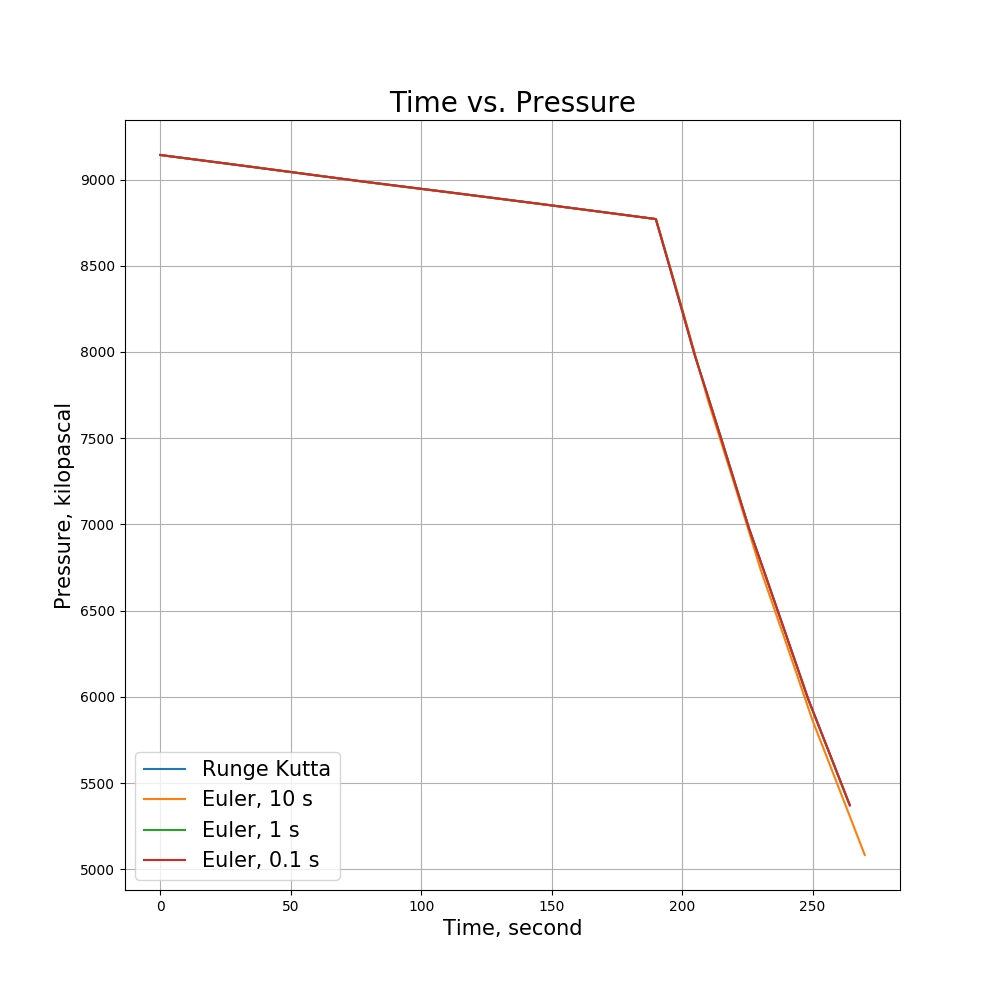

In [70]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Pressure", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Pressure, kilopascal", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,1]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,1]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,1]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,1]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
#plt.xticks(np.arange(min(DATA1[:,0]), max(DATA1[:,0])+1, 10))
plt.show()

<IPython.core.display.Javascript object>


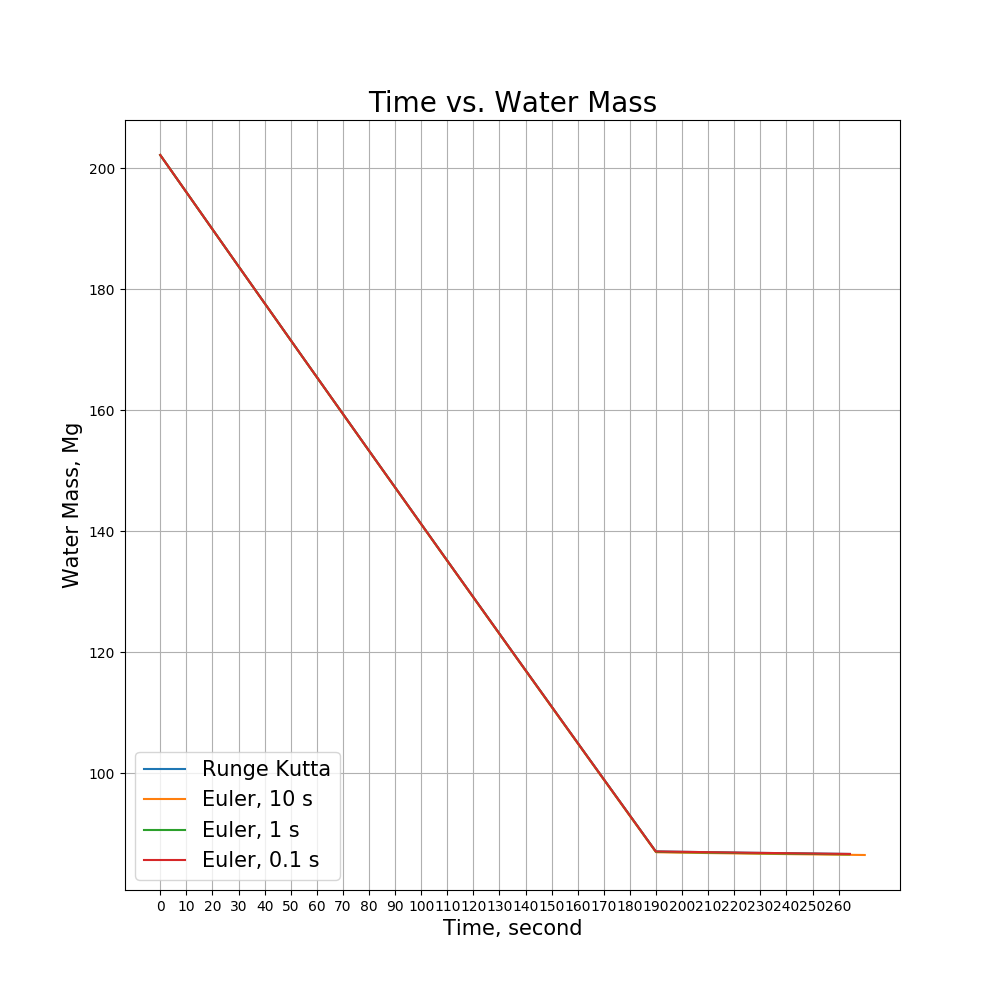

In [69]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,2]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,2]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,2]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,2]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.xticks(np.arange(min(DATA1[:,0]), max(DATA1[:,0])+1, 10))
plt.show()

<IPython.core.display.Javascript object>


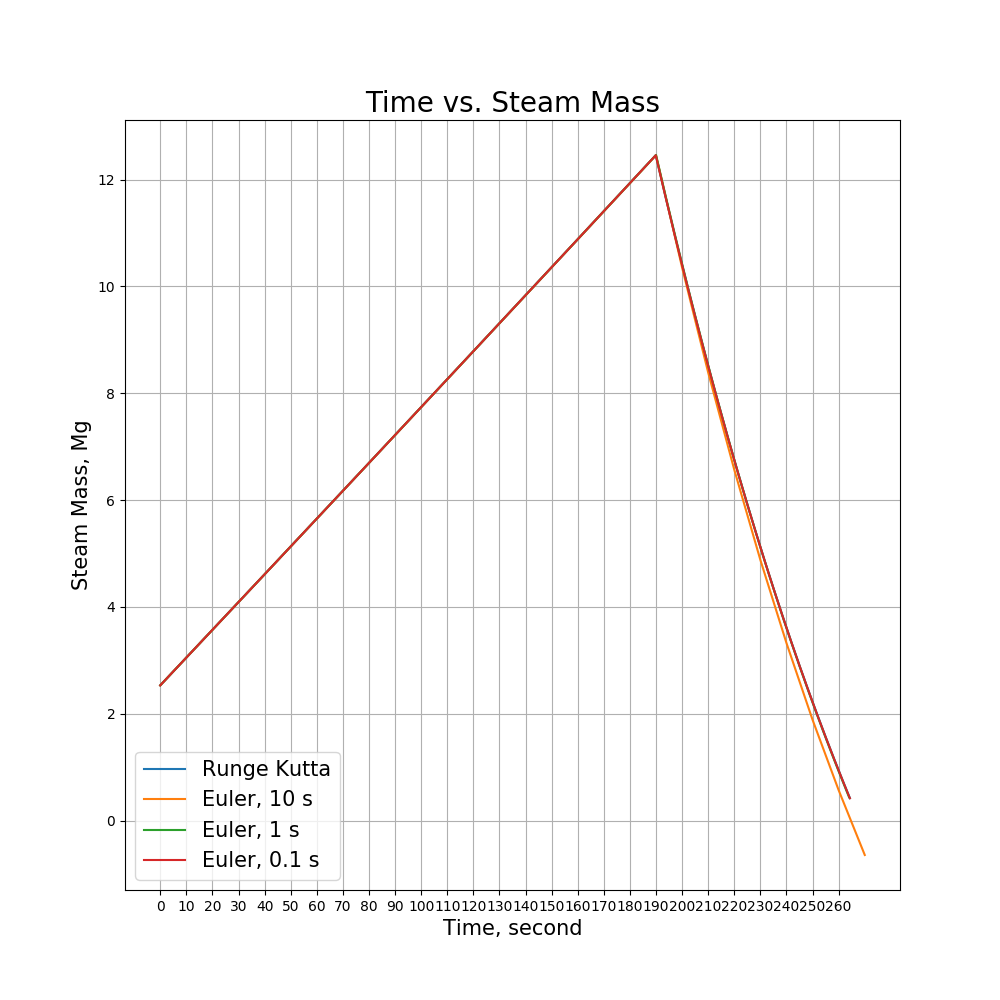

In [65]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Steam Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Steam Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,3]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,3]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,3]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,3]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.xticks(np.arange(min(DATA1[:,0]), max(DATA1[:,0])+1, 10))
plt.show()

<IPython.core.display.Javascript object>


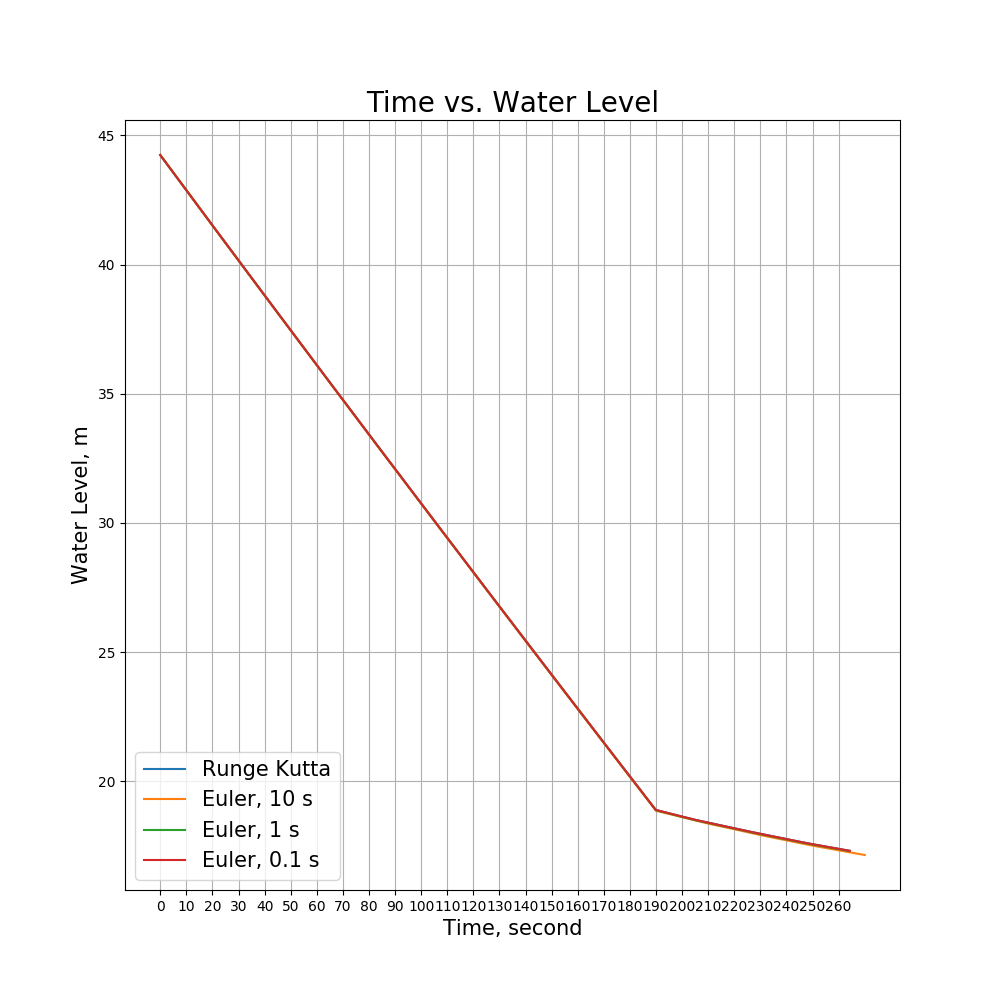

In [66]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Level", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Level, m", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,4], label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,4], label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,4], label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,4], label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.xticks(np.arange(min(DATA1[:,0]), max(DATA1[:,0])+1, 10))
plt.show()

<IPython.core.display.Javascript object>


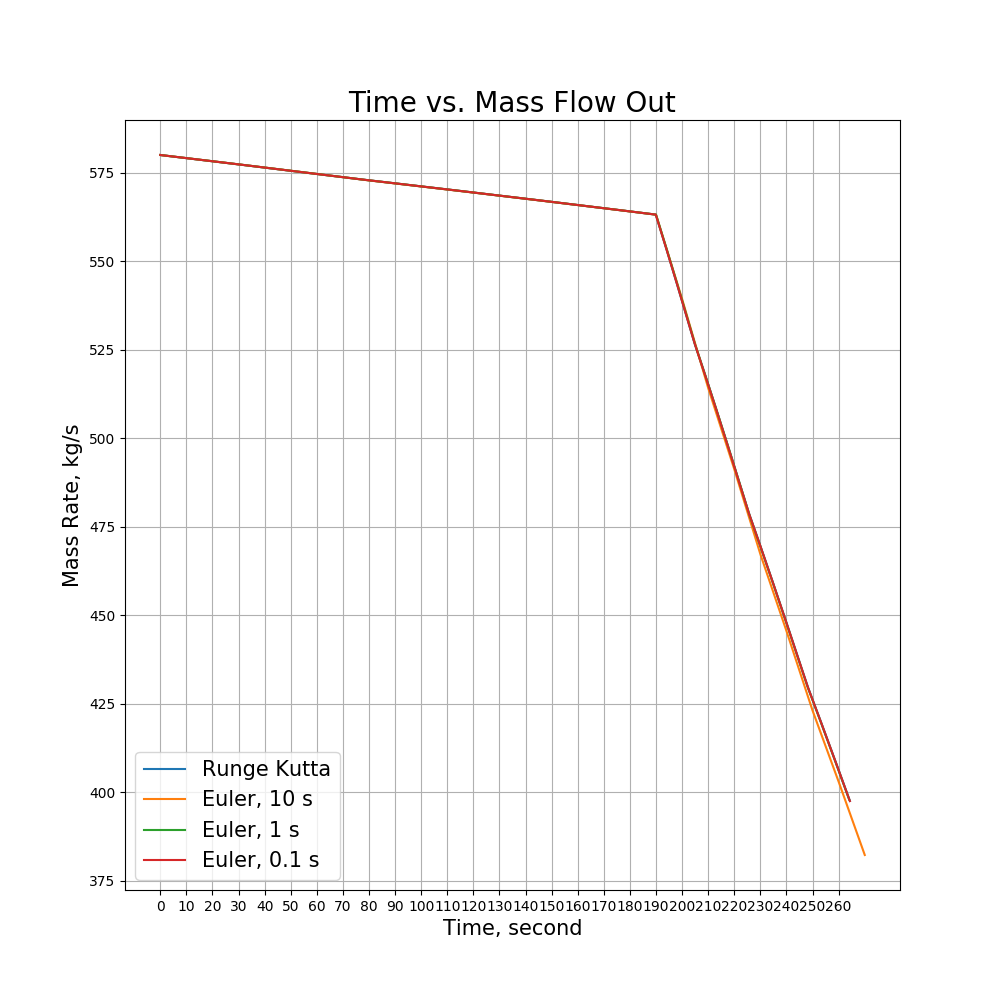

In [67]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Mass Flow Out", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Mass Rate, kg/s", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,5], label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,5], label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,5], label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,5], label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.xticks(np.arange(min(DATA1[:,0]), max(DATA1[:,0])+1, 10))
plt.show()

In [23]:
head2=np.array(['Pressure, pa','Water Mass, kg','Steam Mass, kg','Water Level, m','Mass Flow Rate Out, kg/s'])
Resultdata=pd.DataFrame(np.vstack([DATA1[:5,1:],['Pressure, pa','Water Mass, kg','Steam Mass, kg','Water Level, m','Mass Flow Rate Out, kg/s'],DATA1[1895:1905,1:],['Pressure, pa','Water Mass, kg','Steam Mass, kg','Water Level, m','Mass Flow Rate Out, kg/s'],DATA1[-6:,1:]]),
            index=np.r_[DATA1[:5,0],['...'],DATA1[1895:1905,0],['....'],DATA1[-6:,0]],columns=head2)

Resultdata

,"Pressure, pa","Water Mass, kg","Steam Mass, kg","Water Level, m","Mass Flow Rate Out, kg/s"
0.0,9142448.0,202200.77203839135,2530.9811216897892,44.24111948331539,579.9701731143964
0.1,9142254.178316783,202139.35868859704,2536.1718076915345,44.22747752502005,579.96144329609
0.2,9142060.343635967,202077.94618404726,2541.3625296788227,44.2138358623971,579.9527128386877
0.30000000000000004,9141866.495952826,202016.53452480363,2546.553287654567,44.20019449546499,579.9439817419642
0.4,9141672.635262629,201955.12371092782,2551.744081621681,44.18655342424217,579.9352500056942
...,"Pressure, pa","Water Mass, kg","Steam Mass, kg","Water Level, m","Mass Flow Rate Out, kg/s"
189.49999999999352,8771747.240710955,87358.38564102375,12434.545917156347,18.944523741596996,563.1737739584515
189.5999999999935,8771545.872033577,87298.59559025333,12439.808820866758,18.93146577164666,563.1645946909704
189.6999999999935,8771344.487378396,87238.80642552527,12445.071765190563,18.918408112450898,563.1554146340321
189.7999999999935,8771143.08673672,87179.01814691543,12450.334750131613,18.905350764034385,563.1462337872241


In [ ]:
book = xlsxwriter.Workbook("Testing.xlsx")
sheet1=book.add_worksheet('Pressure')
sheet2=book.add_worksheet('Water Mass')
sheet3=book.add_worksheet('Steam Mass')
sheet4=book.add_worksheet('Water Level')
sheet5=book.add_worksheet('Mass Flow')


def writedata(array=None, sheet=None,col=None):
    for i in np.arange(len(array)):
        sheet.write(i+1,col+1,array[i])

writedata(DATA1[:,0][::100],sheet1,0)
writedata(DATA1[:,1][::100]/1000,sheet1,1)
writedata(DATA2[1][:,1]/1000,sheet1,2)
writedata(DATA3[1][:,1][::10]/1000,sheet1,3)
writedata(DATA4[1][:,1][::100]/1000,sheet1,4)

writedata(DATA1[:,0],sheet2,6)
writedata(DATA1[:,1]/1000,sheet2,7)
writedata(DATA1[:,2]/1000,sheet2,8)
writedata(DATA1[:,3]/1000,sheet2,9)
writedata(DATA1[:,4],sheet2,10)
writedata(DATA1[:,5],sheet2,11)

book.close()